# 2. Tabular Q Learning

In [1]:
from utils.grader import *
from notebooks.internal.exercises_2_tabular_q_learning import *

import numpy as np

## The "Control" Problem
A **reinforcement‑learning agent** interacts with an **environment** in a repeated loop:
1. **Observe & act**  
   The agent observes its current state and chooses an action.

2. **Environment transition**  
   The environment then returns  
   - the next state, drawn randomly from the transition probabilities conditioned on the current state and action, and
   - a numerical reward value.

3. **Repeat**  
   Control returns to Step 1 and the cycle continues until the episode terminates, either because an end-state (terminal state) is reached or because a predefined time step limit is exceeded.

Let us consider an example *environment* where a robot is learning to solve a maze. The environment could either be:
* **Simulated** – defined entirely by software. Modern simulators can step extremely fast, allowing you to run millions of time‑steps per second on a GPU cluster.  
* **Real‑world** — the physical maze itself with a robot that is able to detect its state, select an action, and receive a reward. Here the interaction rate is limited by actuator and sensor latency, often on the order of one action per second. To collect experience faster you would need to run multiple robots in parallel.

Because the simulated environment is faster to train on, you would likely want to train the robot on the simulated environment that replicates the real-world environment, and later deploy the robot in the real-world rather than training there. However, perfect replication remains a challenge, and this is called the "sim-to-real" challenge.

In both cases the formal control loop above remains the same: observe, act, receive the next state and reward, repeat. You can optionally read the following subsection for learning more theoretical background on modelling the agent-environment interaction.

### Optional Background) Markov Decision Processes
We can formally model the agent-environment interaction contract as a **Markov Decision Process** (MDP). This modelling helps us rigorously and clearly define the problem and our assumptions. 

A *Markov Decision Process* $\mathcal{M}$ is described by the elements in the following tuple: $$\mathcal M = \langle \mathcal S,\;\mathcal A,\;P,\;R,\;\gamma\rangle$$

* **States** where each state $s \in \mathcal{A}$ captures the active facts of the system.
* **Actions** in each state $s$ ($s \in \mathcal{S}$), an agent can take an action $a (a \in \mathcal{A}$), which results in a new state $s'$ that is the result of taking the action. Actions can either be deterministic (always ending up in the same resulting state) or probabilistic (ending up in a certain state from a set of states due to stochastic/random/uncertain elements).
* $P(s' \mid s,a)$ is the transition probability from a starting state $s$, taking a particular action $a$, to the next state $s'$.
* $R(s,a,s') = \mathbb E\![\,r_{t+1}\mid s_t=s,\,a_t=a,\,s_{t+1}=s'\,]$ is the expected one-step reward. One-step is defined by the agent starting in state $s$, takes an action $a$, and ends up in the resultant state $s'$.
* $\gamma\in[0,1]$ discounts future rewards

The return can be defined as $G_t$, as below:
$$
G_t \;=\; r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots
$$

The above definitions are quite straightforward, however, you may be wondering what the purpose of a discount factor exactly is. A low discount factor (e.g 0.1) essentially states that getting a smaller reward earlier is better than a large reward much later down the line. In non-episodic RL settings, since the reward horizon may be infinite, you lose convergence guarantees without setting a discount factor. Whereas in episodic RL settings, while you can use a discount factor of 1.0, a slightly smaller $\gamma$ (e.g. 0.99) damps far-future noise, helping reduce variance.

## Finding an Optimal Policy
Recall that a policy is the rulebook that tells the agent which action to take in any particular state. A policy can be *deterministic* (one state maps to one action) or *stochastic* (one state maps to a probability distribution of actions to take). For now, we will assume a deterministic policy.

Our goal is to find an **optimal policy**, which we call $\pi^*$, that maximises the expected return from every state.

### Learning with Model-Based and Model-Free algorithms
There are two key kinds of Reinforcement Learning algorithms we can consider, one is **model-based** algorithms, and the other is **model-free** algorithms. **Model-based** algorithms assume having access to a function which predicts state transitions ($* $P(s' \mid s,a)$) and rewards ($R(s,a,s')$), which we call a model. Analogously, model-free algorithms do not assume access to such a predicting function.

If you have a model, you can perform planning (i.e. "thinking" multiple time steps ahead before performing actions), which in turn increases the sample efficiency of learning (meaning that you do not have to perform as much training). This model can also be learnt from interacting with the environment, with the challenge of learning an accurate representation, particularly with unseen data. However, the real environment dynamics are usually not accessible to the agent or can be costly to compute (e.g. involves calling an external solver). Additionally, vanilla planning techniques are not as suited towards large combinatorial action and state spaces. As model-free algorithms involve a weaker assumption, and thus is more general to learn, we will start with a model-free algorithm known as *Tabular Q-Learning*.

## Tabular Q-Learning
Recall that we want to train our reinforcement‑learning (RL) agent so that it maximises the *cumulative (discounted) return* — the total reward it collects over time.

A common way to achieve this is to learn an action‑value function $Q(s, a)$. From experience, we estimate how advantageous it is to take action $a$ in state $s$ and then follow the current policy thereafter.

<p align="center">
  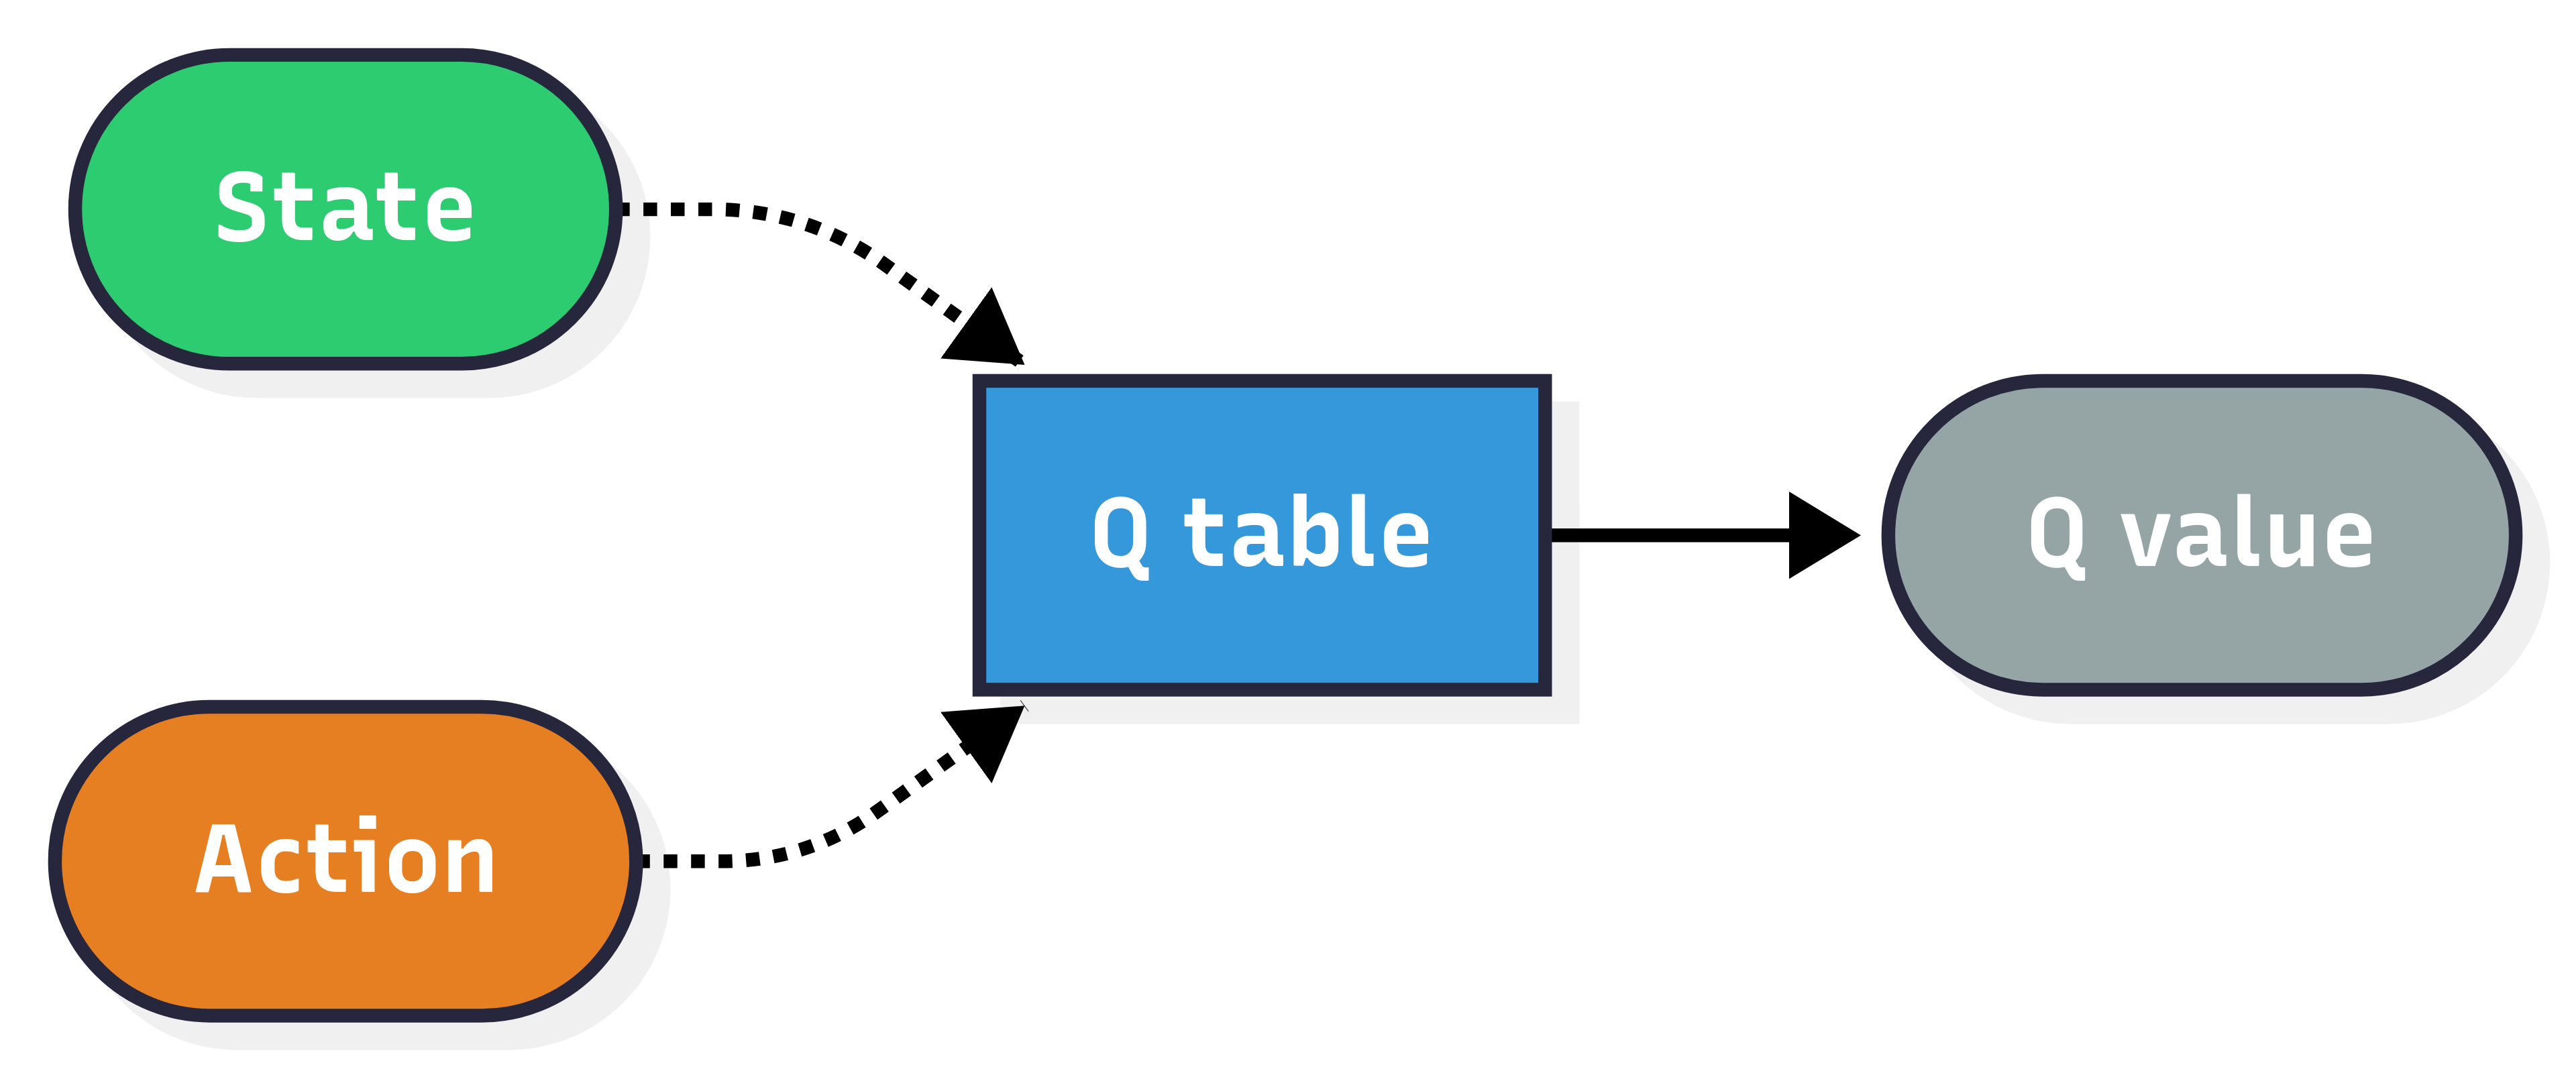
</p>

When the state and action spaces are discrete and not too large, $Q$ can be stored explicitly as a table, with one scalar entry for each $(s, a)$ pair. In larger problems, we would have to approximate $Q$ with a parameterised function (e.g. a neural network).

**That is all Tabular Q‑Learning is: training a table that tells you how valuable every possible state–action pair is.**

### The Bellman Recursive Relationship
The **optimal** action‑value function $Q^*$ satisfies the Bellman optimality equation:
$$Q^*(s,a)=\mathbb E_{s'}\bigl[R_{t+1}+\gamma\max_{a'}Q^*(s',a') \,\big|\, s_t=s,\ a_t=a\bigr]$$

Because $Q^*$ on the right‑hand side is *the very function we are trying to learn*, the update **bootstraps** off its **own, imperfect estimate** of the next state. In practice we do **not** know the expectation over future states and rewards; we only ever see **single samples** $(s,a,r,s')$. Each update therefore uses

* a *sampled* immediate reward $R_{t+1}$, and
* the **current** table entry $\max_{a'}Q(S_{t+1},a')$ as a *proxy* for the (unknown) optimal value of the next state.

Any error in the estimate of the next state propagates backwards through the recursion, which can make learning unstable if the learning‑rate $\alpha$ is too high or the policy does not visit states often enough. Nevertheless, the recursion is also what allows Q‑learning to back‑up information from sparse rewards **without enumerating the entire state space**.

The one‑step tabular update is
$$
\underbrace{Q(S_t,A_t)}_{\text{new Q‑value estimate}}
\;\leftarrow\;
\underbrace{Q(S_t,A_t)}_{\text{former Q‑value estimate}}
\;+\;
\underbrace{\alpha}_{\text{learning rate}}
\,
\overbrace{\Bigl[
      \overbrace{
        \underbrace{R_{t+1}}_{\text{immediate reward}}
        \;+\;
        \underbrace{\gamma\max\limits_{a} Q(S_{t+1},a)}_{\text{discounted estimate of next state}}
      }^{\text{TD target}}
      \;-\;
      \underbrace{Q(S_t,A_t)}_{\text{former Q‑value estimate}}
    \Bigr]}^{\text{TD error}}
$$

### Exploration ↔ Exploitation
In Reinforcement Learning, there is a classical dilemma know as the exploration-exploitation trade-off. At each step, the agent must choose between:
* **exploitation** — taking the action it currently *believes* has the highest value so as to harvest reward now, and
* **exploration** — trying actions that *might* be worse now but could reveal better long‑term returns.

A simple (and still very effective) strategy is **$\varepsilon\$‑greedy** exploration:

* with probability **$1-\varepsilon$** select the greedily optimal action $a^*=\arg\max_a Q(s,a)$ (**exploit**);
* with probability **$\varepsilon$** pick a random action (**explore**).

Typical training schedules start with $\varepsilon\approx0.1\text{–}1.0$ to encourage wide exploration and **decay \$\varepsilon\$ slowly** toward 0 as the table becomes more reliable.

More sophisticated alternatives (e.g. Boltzmann exploration or Upper‑Confidence‑Bound methods) adapt the amount of exploration per state, but $\varepsilon$‑greedy is often sufficient for tabular problems.

### Action masking
When sampling actions, a policy ordinarily considers the full discrete action space $\mathcal A$, regardless of the current state $s$. In many tasks only a subset $A(s)\subseteq \mathcal A$ is actually legal in state $s$.

For example, imagine a 1‑D bin‑packing environment where items arrive sequentially and must be placed into one of $k$ fixed‑capacity bins. By having a mask, you can prevent the agent from performing an illegal action, that is placing an item in an already filled bin.

### Optional Background) On-policy vs Off-policy
A **policy** is the rule an agent follows to choose actions—e.g. an ε‑greedy rule, a softmax distribution or the output of a neural network.

In practice *two* distinct policies matter:

| Policy              | Role in learning                                                                   |
| :-----------------: | :--------------------------------------------------------------------------------: |
| **Behaviour policy** | Interacts with the environment and produces the experience stored in memory        |
| **Target policy**   | The policy you attempt to improve when updating value estimates or network weights |


The following table provides an overview of on-policy vs off-policy algorithms. In on-policy algorithms, the data considered must be gathered by the current policy.

| Aspect                | **On‑policy**                                         | **Off‑policy**                                                                             |
| :----------------------: | :---------------------------------------------------: | :----------------------------------------------------------------------------------------: |
| **Source of data**       | Must come from the *current* policy                   | Can come from *any* policy (earlier checkpoints, exploratory variants, a random policy, …) |
| **Key advantage**        | Learning dynamics are stable and easy to reason about | High sample‑efficiency because past experience can be re‑used                              |
| **Key drawback**         | Discards data after each update (wasteful)            | Risk of divergence if the replay distribution drifts too far from the target policy        |
| **Canonical algorithms** | SARSA, REINFORCE, PPO                                 | Q‑Learning, DQN, SAC, TD3                                                                  |

Tabular **Q‑learning** is off‑policy: the agent *behaves* ε‑greedy (behaviour policy) but each update targets the *greedy* action implied by the current Q‑table (target policy).

Although off‑policy methods dominate when sample efficiency is critical, on‑policy algorithms remain popular when stability and predictable convergence are higher priorities. Some of these considerations are only apparent in non-tabular settings. The key thing to note for you at this stage, is that on-policy algorithms restrict updates to using data from the current policy. Even a slight change to the policy invalidates old data.

##  Programming Tabular Q-Learning
Now that we have all the foundational knowledge required for Tabular Q-Learning, we can now try to code up Tabular Q-Learning. This will be in exercise-based format, as shown in Notebook 1.

#### $\varepsilon-greedy$ exploration
Let us implement our exploration strategy in the following exercise.
1. We must choose when to exploit or explore, based on a probability
2. We must constraint ourselves to a legal action set

In [2]:
def epsilon_greedy(
    values: np.ndarray,
    epsilon: float,
    mask: np.ndarray | None = None,
    seed: int | None = None,
) -> int:
    """Return an action index drawn from an ε-greedy policy.

    Args:
        q_values (1d NumPy array): current estimated q-values.
        epsilon (float scalar): Exploration rate between 0 and 1
        mask (np.ndarray | None, optional):
            Binary vector marking **legal** actions (``1`` → legal, ``0`` → illegal).
            If *None* every action is assumed to be legal.
        seed (int | None, optional):
            If provided, a fresh RNG initialised with this seed is used, making
            the call fully deterministic.
    Returns:
            int: Index of the chosen action.
    """
    rng = np.random.default_rng(seed) if seed is not None else np.random.default_rng()

    # Determine the set of legal actions --------------------------------------
    legal = np.arange(values.size) if mask is None else np.flatnonzero(mask)
    if legal.size == 0:
        raise ValueError("No legal actions available")

    # Exploration -------------------------------------------------------------
    # TODO: Implement this!
    raise NotImplementedError

    # Exploitation ------------------------------------------------------------
    best_idx_within_legal = legal[np.argmax(values[legal])]
    # TODO: Implement this!
    raise NotImplementedError

make_tester(epsilon_greedy, epsilon_greedy_cases)

#### One step Temporal Difference update (TD update)
Next, we shall implement the TD update, according to the following equation we have seen prior:

$$
\underbrace{Q(S_t,A_t)}_{\text{new Q‑value estimate}}
\;\leftarrow\;
\underbrace{Q(S_t,A_t)}_{\text{former Q‑value estimate}}
\;+\;
\underbrace{\alpha}_{\text{learning rate}}
\,
\overbrace{\Bigl[
      \overbrace{
        \underbrace{R_{t+1}}_{\text{immediate reward}}
        \;+\;
        \underbrace{\gamma\max\limits_{a} Q(S_{t+1},a)}_{\text{discounted estimate of next state}}
      }^{\text{TD target}}
      \;-\;
      \underbrace{Q(S_t,A_t)}_{\text{former Q‑value estimate}}
    \Bigr]}^{\text{TD error}}
$$

In [3]:
def td_update(
    q_table: np.ndarray,
    state_idx: int,
    action_idx: int,
    reward: float,
    next_state_idx: int,
    next_mask: np.ndarray | None = None,
    learning_rate: float = 0.1,
    discount_factor: float = 0.99,
) -> float:
    """Perform one 1-step TD (Q-learning) update.

    Args:
        q_table (np.ndarray): Q-value table with shape ``(num_states, num_actions)``.
            The updated value is written in-place.
        state_idx (int): Index of the current state $s_t$.
        action_idx (int): Index of the action taken $a_t$.
        reward (float): Immediate reward $r_{t+1}$.
        next_state_idx (int): Index of the next state $s_{t+1}$.
        next_mask (np.ndarray | None, optional): Binary mask for legal actions
            in $s_{t+1}$ (``1``= legal, 0 = illegal). If *None*,
            every action is considered legal.
        learning_rate (float, optional): Step‑size $\alpha$.
            Defaults to ``0.1``.
        discount_factor (float, optional): Discount factor $\gamma$.
            Defaults to ``0.99``.

    Returns:
        float: The **new** Q-function ``q_table[state_idx, action_idx]``.

    Raises:
        ValueError: If *next_mask* is provided but has no ``1`` entries, i.e.
            there are no legal actions in the next state.
    """
    # ── 1. Determine bootstrap value (td_target) ─────────────────────────────
    next_max = None
    if next_mask is None:
       pass
    else:
        pass

    td_target = None

    # ── 2. Compute TD error and apply update ────────────────────────────────
    td_error = 0
    q_table[state_idx, action_idx] = 0

    return NotImplementedError

make_tester(td_update, td_update_cases)

<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Omar\AppData\Local\Temp\ipykernel_8496\3557948597.py:11: SyntaxWarning: invalid escape sequence '\g'
  """Perform one 1-step TD (Q-learning) update.


# Conclusion

In this notebook, we covered the Reinforcement Learning control problem, with all of the nuances involved, and how to solve it using the most well-known and foundational approach, Tabular Q learning.

We implemented two key functions for Tabular Q Learning, that is, how the exploration-exploitation using $\varepsilon$ -greedy and how the Q-value table is updated after each time step, demonstrating your understanding of all of the details listed above. In future notebooks, we will import a provided reference implementation of Tabular Q Learning, which uses the same logic as here but has all the required helper/training-loop functions. You can view this reference implementation in more detail at `src/rl/tabular_q_learning.py` of the repository, but the important concepts have already been implemented in this notebook.

Solutions to the exercises are also available at `notebooks/solutions/tabular_q_learning.py` in case you are stuck in some implementation detail or perhaps you would simply like to compare your code.

In the next notebook, we will explore how to train and visualise your algorithm in detail, including using hyperparameter tuning rather than trying to guess the optimal learning rate and epsilon yourself!

# Extensions
---
Below are optional extensions to reinforce your understanding of everything covered in this notebook. The above material is sufficient for advancing to the subsequent notebooks, and some of these extensions are quite challenging and time consuming. 

You can also simply revisit these extensions after Notebook 5.

## Extension 1. The Markovian property
> For this task, you will find it useful to read the subsection "Optional Background) Markov Decision Processes"

A *Markov Decision Process* (MDP) is named so because it follows the Markovian property. Explain what the Markovian property is, and provide an example environment where it might be natural to use Non-Markovian Reward Decision Processes.

## Extension 2. Boltzmann Exploration Strategy
Unlike **ε‑greedy**, which picks the current best action with probability 1 − ε and otherwise explores uniformly, *Boltzmann (soft‑max) exploration* samples actions in proportion to the exponentiated Q‑values.

The *temperature* τ (>0) controls how sharp the distribution is: high τ ≈ uniform; low τ → greedy.

In this exercise, replace the exploration/action-selection mechanism in `src/rl/tabular_q_learning.py` with one based on Boltzmann exploration, which often performs better in practice.

**Suggested resources**
* Sutton & Barto, *Reinforcement Learning* (2nd ed.), §2.8 “Gradient Bandit Algorithms”  

## Extension 3. Implement an **On-Policy** Algorithm
> For this task, you will find it useful to read the subsection "Optional Background) On-policy vs Off-policy"
> This is a difficult extension, and can be done after completing the course.

Our Tabular Q-Learning algorithm is an off-policy algorithm. Consider the algorithm `SARSA`, which is an on-policy algorithm.  You should be able to modify the algorithm provided in `src/rl/tabular_learning.py`, updating the TD-target.

$$
Q(s,a) \leftarrow Q(s,a) + \alpha\bigl[r + \gamma Q(s',a') - Q(s,a)\bigr].
$$

Replace the target in `td_update` and train with the same ε‑greedy policy. Compare learning curves with Q‑learning after Notebook 4; SARSA often converges more safely in stochastic domains. For longer‑horizon credit assignment, extend to SARSA(λ) with eligibility traces.

**Suggested resources**
* Sutton & Barto, §6.4 “Sarsa: On‑policy TD Control"  
* Csaba Szepesvári, *Algorithms for RL*, §4.4.1 

# Glossary
---
This will be collated with all notebooks and definitions then updated based on what appears in each notebook. Conclusion will have the full glossary.

- **agent**: the learner/decision‑maker that observes the state, selects actions via a policy, receives rewards, and updates its knowledge to maximize return.
- **action mask:** constraints the action space to only allowing the agent to randomly sample the valid, legal actions (within the rules of the environment) for that particular time step. In some environments, all actions from the action space are always allowed, and thus no mask is needed. Although, very often, an action mask is needed in combinatorial environments.
- **discount factor ($\gamma$)**: a number in $[0,1]$ that down‑weights future rewards when computing return. $\gamma$=0 cares only about immediate reward; $\gamma$ close to 1 values long‑term reward.
- **Markov decision process (MDP)**: a formal model of the environment defined by states $\mathcal{S}$, actions $\mathcal{A}$, transition dynamics $P$, reward function $R$, and discount $\gamma$. 
<!-- "Markov" means the next state and reward depend only on the current state and action, not the full history. -->
- **on‑policy**: learning about the value of the policy you're actually using to act (the behaviour policy). Example: SARSA updates toward what the agent actually did next.
- **off‑policy**: learning about a (possibly optimal) target policy while behaving with a different policy for exploration. Classic example: Q‑learning updates toward the greedy action's value (max over actions) even if it behaved $\varepsilon$‑greedily.
- **policy ($\pi$)**: a mapping from states to actions (deterministic) or to a probability distribution over actions (stochastic), written $\pi(a \mid s)$.
- **scalar**: a 1 dimensional vector, a single numerical value.
- **return ($G_t$)**: is the sum of all rewards obtained, either in a finite window number of time steps, or an infinite-horizon return where all the rewards ever obtained by the agent is considered. The return is said to be a *discounted return* if used with a discount factor $\gamma$.
- **Q‑table**: a table with one entry per (state, action) pair storing the current estimate of its Q‑value. In Tabular Q‑Learning it’s typically a $|S| \times |A|$ array updated as experience is collected.
- **Q‑value**: the expected discounted return starting from state $s$, taking action $a$, then following a policy thereafter. For the optimal Q‑value, $Q^*(s,a)$ uses the optimal policy.
**Q‑function**: the function $Q(s,a)$ that maps any (state, action) to its Q‑value; in tabular methods it’s represented by the Q‑table. Also see the Bellman optimality relation.